# Importing TensorFlow

In [1]:
!nvidia-smi

Sat Jun 22 01:49:31 2024       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.14              Driver Version: 550.54.14      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce RTX 4060 ...    Off |   00000000:01:00.0 Off |                  N/A |
| N/A   42C    P5             19W /  100W |      14MiB /   8188MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [2]:
import tensorflow as tf
print(tf.__version__)

2024-06-22 01:49:32.090986: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-06-22 01:49:32.114486: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-06-22 01:49:32.114505: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-06-22 01:49:32.115109: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-06-22 01:49:32.119217: I tensorflow/core/platform/cpu_feature_guar

2.15.0


In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from dataclasses import dataclass

# Preparing data

In [4]:
def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(False)

def trend(time, slope=0):
    return slope * time

def seasonal_pattern(season_time):
    return np.where(season_time < 0.1,
                    np.cos(season_time * 6 * np.pi), 
                    2 / np.exp(9 * season_time))

def seasonality(time, period, amplitude=1, phase=0):
    season_time = ((time + phase) % period) / period
    return amplitude * seasonal_pattern(season_time)

def noise(time, noise_level=1, seed=None):
    rnd = np.random.RandomState(seed)
    return rnd.randn(len(time)) * noise_level

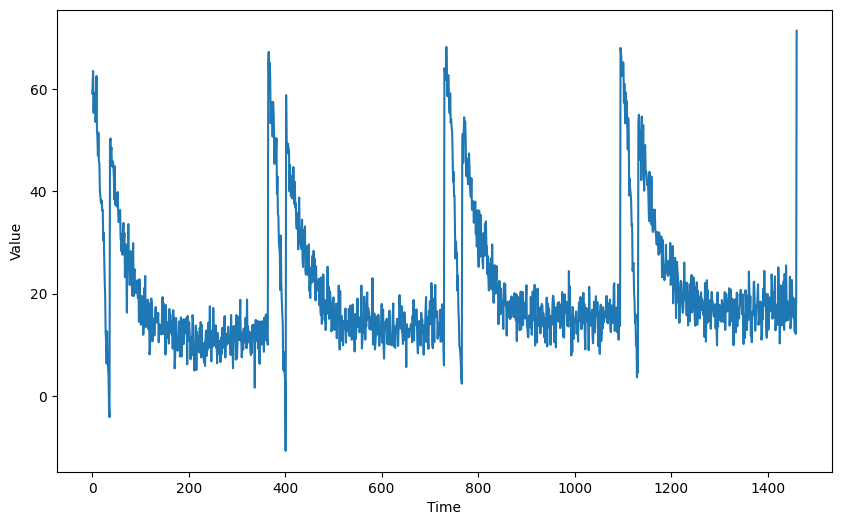

In [5]:
def generate_time_series():
    
    time = np.arange(4 * 365 + 1, dtype="float32")

    y_intercept = 10
    slope = 0.005
    series = trend(time, slope) + y_intercept

    amplitude = 50
    series += seasonality(time, period=365, amplitude=amplitude)

    noise_level = 3
    series += noise(time, noise_level, seed=51)
    
    return time, series

@dataclass
class G:
    TIME, SERIES = generate_time_series()
    SPLIT_TIME = 1100
    WINDOW_SIZE = 20
    BATCH_SIZE = 32
    SHUFFLE_BUFFER_SIZE = 1000


plt.figure(figsize=(10, 6))
plot_series(G.TIME, G.SERIES)
plt.show()

In [6]:
def train_val_split(time, series, time_step=G.SPLIT_TIME):

    time_train = time[:time_step]
    series_train = series[:time_step]
    time_valid = time[time_step:]
    series_valid = series[time_step:]

    return time_train, series_train, time_valid, series_valid


time_train, series_train, time_valid, series_valid = train_val_split(G.TIME, G.SERIES)

In [7]:
series_train

array([59.12849 , 60.274727, 63.495922, ..., 65.180084, 62.56855 ,
       63.612823], dtype=float32)

In [8]:
def windowed_dataset(series, window_size=G.WINDOW_SIZE, batch_size=G.BATCH_SIZE, shuffle_buffer=G.SHUFFLE_BUFFER_SIZE):
    
    dataset = tf.data.Dataset.from_tensor_slices(series)
    dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)
    dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))
    dataset = dataset.shuffle(shuffle_buffer)
    dataset = dataset.map(lambda window: (window[:-1], window[-1]))
    dataset = dataset.batch(batch_size).prefetch(1)
    
    return dataset

In [9]:
test_dataset = windowed_dataset(series_train, window_size=1, batch_size=5, shuffle_buffer=1)

batch_of_features, batch_of_labels = next((iter(test_dataset)))

print(f"batch_of_features has type: {type(batch_of_features)}\n")
print(f"batch_of_labels has type: {type(batch_of_labels)}\n")
print(f"batch_of_features has shape: {batch_of_features.shape}\n")
print(f"batch_of_labels has shape: {batch_of_labels.shape}\n")
print(f"batch_of_features is equal to first five elements in the series: {np.allclose(batch_of_features.numpy().flatten(), series_train[:5])}\n")
print(f"batch_of_labels is equal to first five labels: {np.allclose(batch_of_labels.numpy(), series_train[1:6])}")

batch_of_features has type: <class 'tensorflow.python.framework.ops.EagerTensor'>

batch_of_labels has type: <class 'tensorflow.python.framework.ops.EagerTensor'>

batch_of_features has shape: (5, 1)

batch_of_labels has shape: (5,)

batch_of_features is equal to first five elements in the series: True

batch_of_labels is equal to first five labels: True


2024-06-22 01:49:33.769537: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1929] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 6070 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 4060 Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.9


In [10]:
dataset = windowed_dataset(series_train)

In [11]:
dataset

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, None), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.float32, name=None))>

In [12]:
model_checkpoint = tf.keras.callbacks.ModelCheckpoint(
    "model_checkpoint/cp.weights.h5",
    monitor="loss",
    save_best_only=True,
    save_weights_only=True,
    verbose=0
)

# Creating and training DNN model

In [13]:
dnn_model = tf.keras.models.Sequential([
    tf.keras.layers.Input(shape=[G.WINDOW_SIZE]),
    tf.keras.layers.Dense(100, activation="relu"),
    tf.keras.layers.Dense(10, activation="relu"),
    tf.keras.layers.Dense(1)
])

In [14]:
dnn_model.compile(
    loss = tf.keras.losses.MSE,
    optimizer = tf.keras.optimizers.SGD(learning_rate=1e-6, momentum=0.9)
)

In [15]:
dnn_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 100)               2100      
                                                                 
 dense_1 (Dense)             (None, 10)                1010      
                                                                 
 dense_2 (Dense)             (None, 1)                 11        
                                                                 
Total params: 3121 (12.19 KB)
Trainable params: 3121 (12.19 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


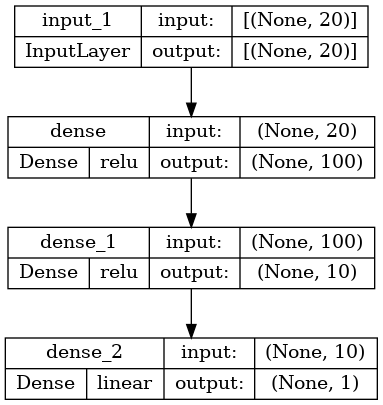

In [16]:
tf.keras.utils.plot_model(dnn_model, show_layer_activations=True, show_shapes=True)

In [17]:
dnn_history = dnn_model.fit(
    dataset,
    epochs=200,
    callbacks = [model_checkpoint]
)

Epoch 1/200


2024-06-22 01:49:34.386885: I external/local_tsl/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2024-06-22 01:49:34.570753: I external/local_xla/xla/service/service.cc:168] XLA service 0x5f429f6e00c0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-06-22 01:49:34.570769: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 4060 Laptop GPU, Compute Capability 8.9
2024-06-22 01:49:34.580233: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8907


34/34 [==============================] - 1s 2ms/step - loss: 457.7588
Epoch 2/200


I0000 00:00:1719010174.601873  578484 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
2024-06-22 01:49:34.748348: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 3063694216929708409
2024-06-22 01:49:34.748374: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 15411837536347040729
2024-06-22 01:49:34.748377: I tensorflow/core/framework/local_rendezvous.cc:425] Local rendezvous send item cancelled. Key hash: 10175014705656511531


34/34 [==============================] - 0s 2ms/step - loss: 104.0534
Epoch 3/200
34/34 [==============================] - 0s 2ms/step - loss: 86.8672
Epoch 4/200
34/34 [==============================] - 0s 2ms/step - loss: 79.3145
Epoch 5/200
34/34 [==============================] - 0s 2ms/step - loss: 73.1629
Epoch 6/200
34/34 [==============================] - 0s 2ms/step - loss: 67.7931
Epoch 7/200
34/34 [==============================] - 0s 2ms/step - loss: 62.9993
Epoch 8/200
34/34 [==============================] - 0s 2ms/step - loss: 58.6935
Epoch 9/200
34/34 [==============================] - 0s 1ms/step - loss: 55.1891
Epoch 10/200
34/34 [==============================] - 0s 2ms/step - loss: 51.9500
Epoch 11/200
34/34 [==============================] - 0s 2ms/step - loss: 49.3936
Epoch 12/200
34/34 [==============================] - 0s 2ms/step - loss: 47.1514
Epoch 13/200
34/34 [==============================] - 0s 2ms/step - loss: 45.3879
Epoch 14/200
34/34 [===============

<Axes: >

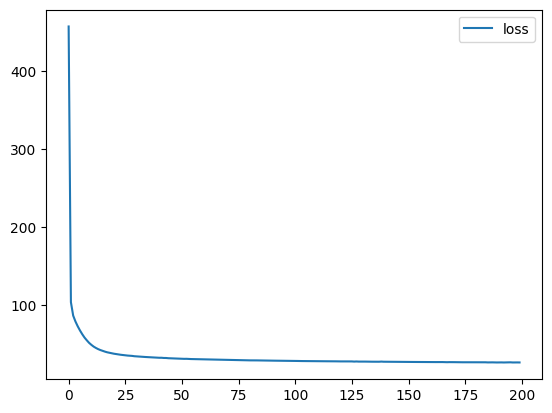

In [18]:
pd.DataFrame(dnn_history.history).plot()

In [19]:
rnn_model = tf.keras.models.Sequential([
    tf.keras.layers.Input(shape=[G.WINDOW_SIZE]),
    tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1)),
    tf.keras.layers.LSTM(100, return_sequences=True),
    tf.keras.layers.Dense(10, activation="relu"),
    tf.keras.layers.Dense(1)
])

In [20]:
rnn_model.compile(
    loss = tf.keras.losses.MSE,
    optimizer = tf.keras.optimizers.SGD(learning_rate=1e-6, momentum=0.9)
)

In [21]:
rnn_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lambda (Lambda)             (None, 20, 1)             0         
                                                                 
 lstm (LSTM)                 (None, 20, 100)           40800     
                                                                 
 dense_3 (Dense)             (None, 20, 10)            1010      
                                                                 
 dense_4 (Dense)             (None, 20, 1)             11        
                                                                 
Total params: 41821 (163.36 KB)
Trainable params: 41821 (163.36 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


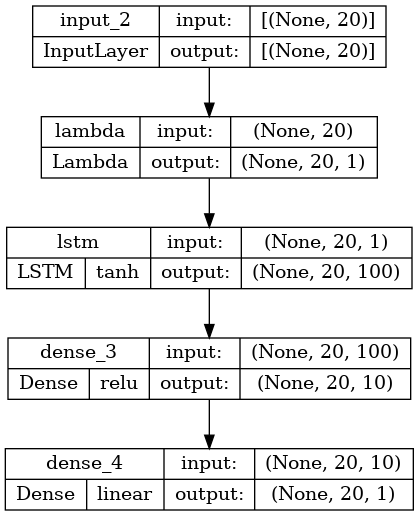

In [22]:
tf.keras.utils.plot_model(rnn_model, show_layer_activations=True, show_shapes=True)

In [23]:
rnn_history = rnn_model.fit(
    dataset,
    epochs=200,
    callbacks = [model_checkpoint]
)

Epoch 1/200
34/34 [==============================] - 1s 2ms/step - loss: 498.0261
Epoch 2/200
34/34 [==============================] - 0s 3ms/step - loss: 478.6137
Epoch 3/200
 1/34 [..............................] - ETA: 1s - loss: 323.8043

2024-06-22 01:49:54.106918: I tensorflow/core/framework/local_rendezvous.cc:425] Local rendezvous send item cancelled. Key hash: 630239666770974727
2024-06-22 01:49:54.106943: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 3063694216929708409
2024-06-22 01:49:54.106947: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 11323863134291033195
2024-06-22 01:49:54.106955: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 15762525959513479520
2024-06-22 01:49:54.106957: I tensorflow/core/framework/local_rendezvous.cc:425] Local rendezvous send item cancelled. Key hash: 1578383782001151320


34/34 [==============================] - 0s 3ms/step - loss: 458.8831
Epoch 4/200
34/34 [==============================] - 0s 3ms/step - loss: 443.4243
Epoch 5/200
34/34 [==============================] - 0s 3ms/step - loss: 427.9684
Epoch 6/200
34/34 [==============================] - 0s 2ms/step - loss: 410.9042
Epoch 7/200
34/34 [==============================] - 0s 3ms/step - loss: 393.6412
Epoch 8/200
34/34 [==============================] - 0s 3ms/step - loss: 375.9474
Epoch 9/200
34/34 [==============================] - 0s 3ms/step - loss: 357.3306
Epoch 10/200
34/34 [==============================] - 0s 3ms/step - loss: 338.0264
Epoch 11/200
34/34 [==============================] - 0s 2ms/step - loss: 318.0423
Epoch 12/200
34/34 [==============================] - 0s 3ms/step - loss: 297.9904
Epoch 13/200
34/34 [==============================] - 0s 2ms/step - loss: 278.1866
Epoch 14/200
34/34 [==============================] - 0s 3ms/step - loss: 259.0052
Epoch 15/200
34/34 [===

KeyboardInterrupt: 

In [ ]:
pd.DataFrame(rnn_history.history).plot()

# Evaluating

In [24]:
def compute_metrics(true_series, forecast):
    
    mse = tf.keras.metrics.mean_squared_error(true_series, forecast).numpy()
    mae = tf.keras.metrics.mean_absolute_error(true_series, forecast).numpy()

    return mse, mae

In [25]:
def generate_forecast(model, series=G.SERIES, split_time=G.SPLIT_TIME, window_size=G.WINDOW_SIZE):
    forecast = []
    for time in range(len(series) - window_size):
        forecast.append(model.predict(series[time:time + window_size][np.newaxis]))

    forecast = forecast[split_time-window_size:]
    results = np.array(forecast)[:, 0, 0]
    return results

In [26]:
dnn_forecast = generate_forecast(model=dnn_model)

1/1 [==============================] - 0s 19ms/step


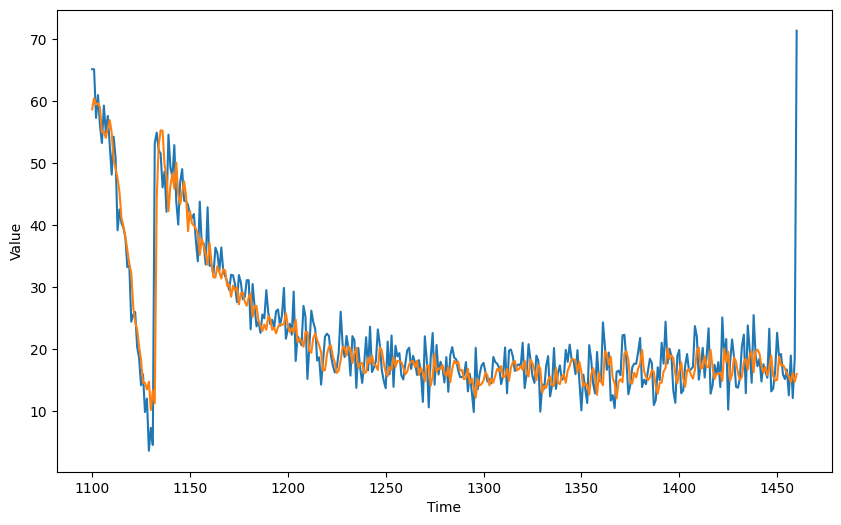

In [27]:
plt.figure(figsize=(10, 6))
plot_series(time_valid, series_valid)
plot_series(time_valid, dnn_forecast)

In [28]:
mse, mae = compute_metrics(series_valid, dnn_forecast)

print(f"mse: {mse:.2f}, mae: {mae:.2f} for dnn_model forecast")

mse: 27.84, mae: 3.23 for dnn_model forecast
